# Electronic Supplement

This notebook accompanies the paper *"Hodge Laplacian on 1-forms of homogeneous 3-spheres"*. It visualizes the *full spectrum for 1-forms* on the Berger spheres and provides numerical verifications of the *first eigenvalue conjecture*.

We conjecture that for *any homogeneous metric on SU(2)*, the first eigenvalue of the Hodge-Laplacian on 1-forms is the minimum of:
1.  The first eigenvalue of the Laplacian on functions (acting on the representation space).
2.  The first eigenvalue of the operator acting purely on the fiber.

## Table of Contents
1. [Implementation of the Hodge-Laplacian](#setup)
   - Definition of $\mathfrak{su}(2)$ representations and the Weitzenböck formula.
2. [Explicit Matrix Representations](#matrices)
   - Visualization of the operator matrices for low weights $k$.
3. [Symbolic Spectrum](#eigenvalues)
   - Exact calculation of eigenvalues for $k=0, 1, 2, 3$.
4. [Monte Carlo Stress Test](#montecarlos)
   - Numerical verification of the conjecture using random metrics.
5. [Full Spectrum of Berger Spheres](#plots)
   - Visualization of the eigenvalue evolution for Berger metrics.

## <a name="setup"></a>1. Implementation of the Hodge-Laplacian

We implement the Hodge-Laplacian $\Delta = \nabla^*\nabla + 2q(R)$ acting on 1-forms using the standard basis for the irreducible representations $V_k$ of $\mathfrak{su}(2)$.

**Usage of the `Delta` function:**
The core function `Delta(k, a_val, b_val, c_val, numeric)` constructs the operator matrix.
*   **Default Behavior:** If the metric parameters `a_val`, `b_val`, `c_val` are omitted (or `None`), the function defaults to using global symbolic variables `var('a b c')`.
*   **Symbolic Mode (`numeric=False`):** Uses the Symbolic Ring (`SR`) to produce exact algebraic formulas. Useful for deriving closed-form expressions for low $k$.
*   **Numeric Mode (`numeric=True`):** Uses the Complex Double Field (`CDF`) for high-performance numerical computations. This is essential for the stress tests and plotting high $k$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define symbolic variables
var('a b c')
assume(a > 0, b > 0, c > 0)

def get_reps(k):
    """
    Returns the su(2) representation matrices E1, E2, E3 for weight k.
    Dimension of the matrix is k+1. 
    """
    dim = k + 1
    # Initialize matrices in Symbolic Ring (SR)
    E1 = Matrix(SR, dim, dim, 0)
    E2 = Matrix(SR, dim, dim, 0)
    E3 = Matrix(SR, dim, dim, 0)
    
    for l in range(dim):
        # E1: Diagonal elements (weights)
        E1[l, l] = I * (k - 2*l)
        
        # E2: Real part of ladder operators
        if l > 0:
            E2[l-1, l] = -l           # Contribution from P_{l-1}
        if l < k:
            E2[l+1, l] = k - l        # Contribution from P_{l+1}
        
        # E3: Imaginary part of ladder operators
        if l > 0:
            E3[l-1, l] = -l * I
        if l < k:
            E3[l+1, l] = -(k - l) * I
            
    return E1, E2, E3

def get_curv(a, b, c):
    """
    Calculates the eigenvalues r_ij of the curvature operator R on 2-vectors. 
    Note: Based on the definition R(X^Y) = 0.5 * sum(E_i ^ R(X,Y)E_i),
    these eigenvalues are NEGATIVE for the standard sphere (a=b=c=1).
    """
    r12 = 3*a**2*b**2/c**2 - a**2*c**2/b**2 - b**2*c**2/a**2 - 2*a**2 - 2*b**2 + 2*c**2
    r13 = -a**2*b**2/c**2 + 3*a**2*c**2/b**2 - b**2*c**2/a**2 - 2*a**2 + 2*b**2 - 2*c**2
    r23 = -a**2*b**2/c**2 - a**2*c**2/b**2 + 3*b**2*c**2/a**2 + 2*a**2 - 2*b**2 - 2*c**2
    return r12, r13, r23

def Delta(k, a_val=None, b_val=None, c_val=None, numeric=False):
    """
    Constructs the Hodge-Laplacian matrix Delta for representation k.
    If a_val, b_val, c_val are provided, substitutes them.
    If numeric=True, builds the matrix directly in CDF for speed.
    """
    # 1. Decide on the ring (Symbolic or Numeric)
    if numeric and a_val is not None:
        R = CDF
        # Pre-calculate constants as numbers
        a, b, c = float(a_val), float(b_val), float(c_val)
    else:
        R = SR
        # Use symbolic variables if not provided
        if a_val is None: a_val, b_val, c_val = var('a b c')
        a, b, c = a_val, b_val, c_val

    # 2. Get representation matrices
    # We cast them to the target ring R immediately
    E1_raw, E2_raw, E3_raw = get_reps(k)
    E1 = E1_raw.change_ring(R)
    E2 = E2_raw.change_ring(R)
    E3 = E3_raw.change_ring(R)
    
    dim_rep = E1.nrows()
    
    # Identity matrices
    id_rep = identity_matrix(R, dim_rep)
    id_form = identity_matrix(R, 3) # 1-forms are 3D
    
    # 3. Connection matrices N (Levi-Civita on 1-forms)
    # Note: N_i represents -Gamma_{i, .}^.
    # Terms like (ab/c + ac/b - bc/a) appear frequently.
    
    # We calculate the terms directly in the ring R
    val_N1_23 = -(-a*b/c - a*c/b + b*c/a)
    val_N1_32 = -a*b/c - a*c/b + b*c/a
    
    val_N2_13 = -(a*b/c - a*c/b + b*c/a)
    val_N2_31 = a*b/c - a*c/b + b*c/a
    
    val_N3_12 = -(a*b/c - a*c/b - b*c/a)
    val_N3_21 = a*b/c - a*c/b - b*c/a
    
    # Construct matrices directly in R
    N1 = -1 * Matrix(R, [
        [0, 0, 0],
        [0, 0, val_N1_23],
        [0, val_N1_32, 0]
    ])
    
    N2 = -1 * Matrix(R, [
        [0, 0, val_N2_13],
        [0, 0, 0],
        [val_N2_31, 0, 0]
    ])
    
    N3 = -1 * Matrix(R, [
        [0, val_N3_12, 0],
        [val_N3_21, 0, 0],
        [0, 0, 0]
    ])
    
    # 4. Casimir Operators
    # Casimir on V_k (E_i are anti-hermitian, so squares are negative)
    Cas_rep = (a**2 * E1*E1 + b**2 * E2*E2 + c**2 * E3*E3)
    
    # Casimir on 1-forms
    Cas_form = N1*N1 + N2*N2 + N3*N3
    
    # Mixed interaction term
    Mixed = 2*a*E1.tensor_product(N1) + 2*b*E2.tensor_product(N2) + 2*c*E3.tensor_product(N3)
    
    # 5. Curvature term q(R) (Ricci)
    r12, r13, r23 = get_curv(a, b, c)
    
    # q(R) acts diagonally. Since r_ij are negative, (-r_ij - r_ik) yields positive Ricci curvature.
    qR = diagonal_matrix(R, [-r12-r13, -r23-r12, -r23-r13])
    
    # 6. Assemble Delta = nabla*nabla + 2q(R)
    # Rough Laplacian = -(Cas_rep + Cas_form + Mixed)
    RoughLaplacian = -(Cas_rep.tensor_product(id_form) + id_rep.tensor_product(Cas_form) + Mixed)
    CurvatureTerm = id_rep.tensor_product(qR)
    
    Delta = RoughLaplacian + CurvatureTerm
    if not numeric:
       Delta = Delta.apply_map(lambda x: x.expand())
            
    return Delta


## <a name="matrices"></a>2. Explicit Matrix Representations

We display the symbolic form of the Hodge-Laplacian. You can adjust the loop variable to inspect the matrix structure for higher representations $k$. Note that the matrix dimension grows as $3(k+1) \times 3(k+1)$.

In [17]:
from IPython.display import display, Math
import os

# Configuration
K_MAX_MATRIX = 5
OUTPUT_FILE_MAT = "explicit_matrices.txt"

with open(OUTPUT_FILE_MAT, "w") as f:
    f.write("EXPLICIT HODGE-LAPLACIAN MATRICES\n===================================\n\n")

    for k in range(K_MAX_MATRIX + 1):
        M = Delta(k, numeric=False)
        rows, cols = M.nrows(), M.ncols()
        
        display(Math(f"\\textbf{{Representation }} k = {k} \\quad (\\text{{Dimension }} {rows} \\times {cols})"))
        
        # Save full matrix to file
        f.write(f"Matrix k={k} ({rows}x{cols}):\n{M}\n\n{'-'*40}\n\n")
        
        # Display in Notebook
        if k < 2:
            display(Math(latex(M)))
        else:
            # Escape underscore for LaTeX display
            fname_tex = OUTPUT_FILE_MAT.replace('_', r'\_')
            display(Math(r"\text{Matrix too large for inline display.}"))
            display(Math(rf"\text{{Full matrix exported to }} \texttt{{{fname_tex}}}"))
            
        print("-" * 60)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------------------------------------


## <a name="eigenvalues"></a>3. Symbolic Spectrum

We compute the exact symbolic eigenvalues for low weights.
*   For $k=0$, the operator acts purely on the fiber. The spectrum is determined by the operator $-C_{\nabla}^{\mathfrak{su}(2)} + 2q(R)$.
*   For $k=1$, we observe the splitting into exact and co-closed forms.
*   For $k \ge 2$, the expressions become significantly more complex as they involve roots of polynomials of degree 3 ($k=2$) and degree 4 ($k=3$).

In [21]:
from IPython.display import display, Math
import os

# Configuration
K_MAX_EIG = 3
OUTPUT_FILE_EIG = "exact_eigenvalues.txt"

with open(OUTPUT_FILE_EIG, "w") as f:
    f.write("EXACT SYMBOLIC EIGENVALUES\n==========================\n\n")

    for k in range(K_MAX_EIG + 1):
        M = Delta(k, numeric=False)
        evals = M.eigenvalues()
        
        display(Math(f"\\textbf{{Spectrum for }} k={k}:"))
        f.write(f"Spectrum k={k}:\n{'-'*20}\n")
        
        for i, eig in enumerate(evals):
            # Simplification strategy
            if k == 1:
                # For k=1, radical canonicalization yields the most compact form
                eig_disp = eig.canonicalize_radical()
            else:
                # For other cases, factoring is usually sufficient
                try:
                    eig_disp = eig.factor()
                except:
                    eig_disp = eig
            
            # Save to file
            f.write(f"Lambda_{i+1}:\n{eig_disp}\n\n")
            
            # Display in Notebook
            if k < 2:
                display(Math(f"\\lambda_{{{i+1}}} = " + latex(eig_disp)))
            elif i == 0:
                fname_tex = OUTPUT_FILE_EIG.replace('_', r'\_')
                display(Math(r"\text{Explicit formulas are too large for inline display.}"))
                display(Math(rf"\text{{Full results exported to }} \texttt{{{fname_tex}}}"))
                
        print("=" * 60)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## <a name="montecarlos"></a>4. Monte Carlo Stress Test

We perform a numerical stress test to verify the conjecture regarding the smallest eigenvalue.

> **The Conjecture:**
> For any homogeneous metric on $SU(2)$, the first eigenvalue of the Hodge-Laplacian on 1-forms is attained at representation weight $k=0$ or $k=1$.
> Specifically, it is the minimum of the first eigenvalue on functions ($k=1$) and the first eigenvalue of the fiber-wise operator ($k=0$).

**Configuration:**
*   `K_MIN` / `K_MAX`: Defines the range of representations to check.
*   `NUM_ITERATIONS`: The number of random metrics to generate.

**Methodology:**
The script generates `NUM_ITERATIONS` random metrics. For *each single representation weight $k$* within the interval $[K_{min}, K_{max}]$, these metrics are tested separately to ensure the eigenvalue never drops below the baseline established by $k=0,1$.

In [5]:
import random
import numpy as np

# --- CONFIGURATION ---
K_MIN = 2
K_MAX = 10
NUM_ITERATIONS = 1000
# ---------------------

def get_min_eigenvalue(k, a, b, c):
    """
    Helper function to compute the smallest eigenvalue (real part).
    """
    # Use numeric=True and CDF for performance
    M = Delta(k, a, b, c, numeric=True)
    evals = M.eigenvalues()
    return min([e.real() for e in evals])

print("-" * 60)
print(f"STRESS TEST: {NUM_ITERATIONS} Random Metrics")
print(f"Checking range: k = {K_MIN} to {K_MAX}")
print("-" * 60)

counter = 0
found_counterexample = False

for i in range(NUM_ITERATIONS):
    # Generate random parameters a, b, c between 0.1 and 10
    ra = random.uniform(0.1, 10)
    rb = random.uniform(0.1, 10)
    rc = random.uniform(0.1, 10)
    
    # 1. Determine Baseline (minimum of k=0 and k=1)
    l0 = get_min_eigenvalue(0, ra, rb, rc)
    l1 = get_min_eigenvalue(1, ra, rb, rc)
    baseline = min(l0, l1)
    
    # 2. Check range of k
    for k in range(K_MIN, K_MAX + 1):
        l_k = get_min_eigenvalue(k, ra, rb, rc)
        
        # Compare with tolerance
        if l_k < baseline - 1e-6: 
            print(f"\nCOUNTEREXAMPLE FOUND at iteration {i}!")
            print(f"Parameters: a={ra:.4f}, b={rb:.4f}, c={rc:.4f}")
            print(f"Min(k=0,1) = {baseline:.4f}")
            print(f"Min(k={k})   = {l_k:.4f}")
            found_counterexample = True
            break # Break inner loop
    
    if found_counterexample:
        break # Break outer loop
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} metrics tested (checking all k in {K_MIN}..{K_MAX})... no violations found.")

if not found_counterexample:
    print(f"\nSUCCESS: No violation of the conjecture found in {NUM_ITERATIONS} random metrics.")
    print(f"For each metric, the spectrum was checked for all representations k={K_MIN} to {K_MAX}.")
    print(f"The global minimum appears to be consistently attained at k=0 or k=1.")

------------------------------------------------------------
STRESS TEST: 1000 Random Metrics
Checking range: k = 2 to 10
------------------------------------------------------------
100 metrics tested (checking all k in 2..10)... no violations found.
200 metrics tested (checking all k in 2..10)... no violations found.
300 metrics tested (checking all k in 2..10)... no violations found.
400 metrics tested (checking all k in 2..10)... no violations found.
500 metrics tested (checking all k in 2..10)... no violations found.
600 metrics tested (checking all k in 2..10)... no violations found.
700 metrics tested (checking all k in 2..10)... no violations found.
800 metrics tested (checking all k in 2..10)... no violations found.
900 metrics tested (checking all k in 2..10)... no violations found.
1000 metrics tested (checking all k in 2..10)... no violations found.

SUCCESS: No violation of the conjecture found in 1000 random metrics.
For each metric, the spectrum was checked for all repre

## <a name="plots"></a>5. Full Spectrum of Berger Spheres

We visualize the spectrum for Berger metrics ($b=c=1$) depending on the parameter $a$.

**Context:**
These plots illustrate the first Hodge spectrum of the canonical variation of a Riemannian submersion with totally geodesic fibers. While the spectral behavior for functions was previously established by *Bérard-Bergery and Bourguignon (1982)*, here we visualize the complicated splitting behavior for 1-forms.

**The Smallest Eigenvalue:**
For Berger metrics, the first eigenvalue is explicitly given by the minimum of the exact forms ($k=1$) and the fiber-wise operator ($k=0$):
$$ \lambda_{min}(g_{a,1,1}) = \min\left( \underbrace{a^2+2}_{k=1}, \quad \underbrace{\frac{4}{a^2}}_{k=0, \text{Type } 3}, \quad \underbrace{4a^2}_{k=0, \text{Type } 2} \right) $$

**Usage of `plot_berger_spectrum`:**
The function allows for selective visualization of specific eigenvalue types. You can toggle the visibility of different spectral branches by setting the corresponding arguments to `True` or `False`:
*   `show_nu`: Spectrum of functions (Type 1).
*   `show_mu_bound`: Fiber eigenvalues (Type 2).
*   `show_mu_center`: Mixed terms (Type 3).
*   `show_mu_plus` / `show_mu_minus`: Complicated root terms (Type 4).

In [8]:

import numpy as np

# 1. Type: Nu (Functions)
def val_nu(k, j, a):
    # nu_{k,j} = k(k+2) - (k-2j)^2 + a^2(k-2j)^2
    return k*(k+2) - (k-2*j)**2 + a**2 * (k-2*j)**2

# 2. Type: Mu boundary (Fibre eigenvalues)
def val_mu_boundary(k, a):
    # mu_{k, k+1} = (k+2)^2 * a^2
    return (k+2)**2 * a**2

# 3. Type: Mu center (Mixed terms)
def val_mu_center(k, a):
    # mu_{k, k} = k^2 a^2 + 4k + 4/a^2
    return k**2 * a**2 + 4*k + 4/a**2

# 4. Type: Mu +/- (The complex ones)
def val_mu_pm(k, j, a, sign=+1):
    # nu term
    nu = val_nu(k, j, a)
    # root term: sqrt(a^2 * nu + 1)  (since b=1)
    root_term = np.sqrt(a**2 * nu + 1)
    
    # mu = nu + 2/a^2 +/- (2/a^2) * root
    term_inv_a2 = 2 / a**2
    
    return nu + term_inv_a2 + sign * term_inv_a2 * root_term


def plot_berger_spectrum(
    k_max=8, 
    a_max=3.0, 
    y_max=150, 
    title="Spectrum", 
    show_nu=True, 
    show_mu_bound=True, 
    show_mu_center=True, 
    show_mu_plus=True, 
    show_mu_minus=True,
    specific_k=None,
    resolution=500
):
    # Setup a range
    a = np.linspace(0.01, a_max, resolution)
    
    plt.figure(figsize=(12, 8))
    
    if specific_k is not None:
        k_range = [specific_k]
    else:
        k_range = range(k_max + 1)

    for k in k_range:
        if show_nu:
            for j in range(k + 1):
                y = val_nu(k, j, a)
                plt.plot(a, y, color='royalblue', linewidth=1.2, alpha=0.9)

        if show_mu_bound:
            y = val_mu_boundary(k, a)
            plt.plot(a, y, color='forestgreen', linewidth=1.5, alpha=0.9)

        if show_mu_center:
            y = val_mu_center(k, a)
            plt.plot(a, y, color='firebrick', linewidth=1.5, alpha=0.9)

        if k >= 2:
            for j in range(1, k):
                if show_mu_plus:
                    y_plus = val_mu_pm(k, j, a, sign=+1)
                    plt.plot(a, y_plus, color='purple', linewidth=1.2, alpha=0.8)
                
                if show_mu_minus:
                    y_minus = val_mu_pm(k, j, a, sign=-1)
                    plt.plot(a, y_minus, color='darkorange', linewidth=1.2, alpha=0.8)

    plt.ylim(0, y_max)
    plt.xlim(0, a_max)
    
    # Labels
    plt.xlabel(r'$a$', fontsize=14)
    plt.ylabel(r'$\Sigma(SU(2), g_{a,1,1})$', fontsize=14)
    plt.title(title, fontsize=16, pad=20)
    
    # Legend Setup
    from matplotlib.lines import Line2D
    legend_elements = []
    if show_nu: legend_elements.append(Line2D([0], [0], color='royalblue', label=r'$\nu_{k,j}$'))
    if show_mu_bound: legend_elements.append(Line2D([0], [0], color='forestgreen', label=r'$\mu_{k,k+1}$'))
    if show_mu_center: legend_elements.append(Line2D([0], [0], color='firebrick', label=r'$\mu_{k,k}$'))
    if show_mu_plus: legend_elements.append(Line2D([0], [0], color='purple', label=r'$\mu_{k,j}^+$'))
    if show_mu_minus: legend_elements.append(Line2D([0], [0], color='darkorange', label=r'$\mu_{k,j}^-$'))
    
    # FIX: 'upper center' sorgt dafür, dass die Legende nach UNTEN wächst
    # bbox_to_anchor=(0.5, -0.12) platziert die Oberkante der Legende unter das Label 'a'
    plt.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.12))
    
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.minorticks_on()
    
    # Tight Layout mit Padding für die Legende unten
    plt.tight_layout()
    # Manuell etwas Platz unten reservieren, damit die Legende nicht abgeschnitten wird
    plt.subplots_adjust(bottom=0.15)
    
    plt.show()

### Full Spectrum Overview (Figure 1)

This plot shows the superposition of all eigenvalues for representations up to **$k=8$**. It illustrates the dense overlap of spectral lines that occurs when considering multiple representations at once.

**Color Coding of Eigenvalue Types:**
*   <span style="color:royalblue">**Blue ($\nu_{k,j}$):**</span> Spectrum of functions (Type 1).
*   <span style="color:forestgreen">**Green ($\mu_{k,k+1}$):**</span> Fiber-dominated eigenvalues (Type 2).
*   <span style="color:firebrick">**Red ($\mu_{k,k}$):**</span> Mixed terms (Type 3).
*   <span style="color:purple">**Purple ($\mu_{k,j}^+$)**</span> /<span style="color:darkorange">**Orange ($\mu_{k,j}^-$):**</span> Complicated splitting terms (Type 4).

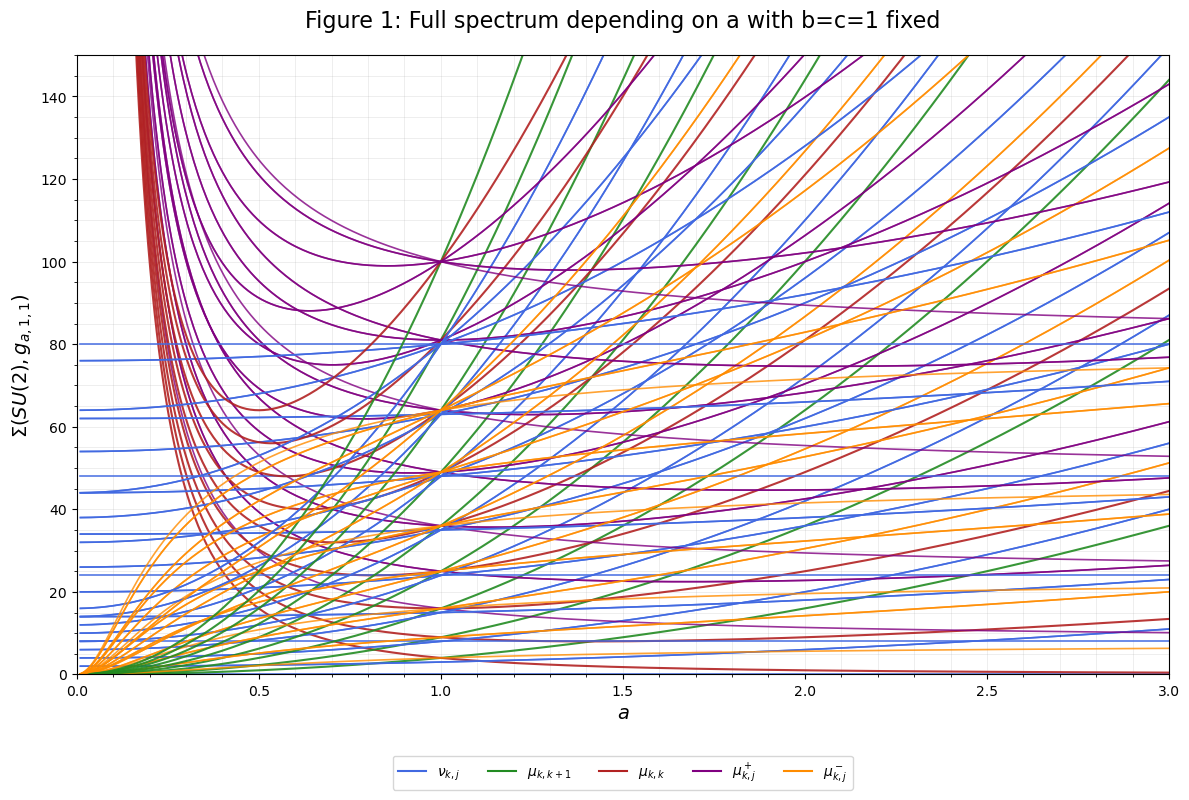

In [9]:
plot_berger_spectrum(k_max=8, a_max=3.0, y_max=150, 
                     title="Figure 1: Full spectrum depending on a with b=c=1 fixed")

### Type 1: Spectrum of Functions (Figure 2)

This plot displays the Type 1 eigenvalues $\nu_{k,j}$. These correspond exactly to the spectrum of the Laplacian on functions.
The behavior follows the general pattern expected for canonical variations of a Riemannian submersion with totally geodesic fibers. The eigenvalues are composed of the horizontal part (total eigenvalue minus fiber eigenvalue) and the rescaled vertical part:

$$ \nu_{k,j} = \underbrace{\left[ k(k+2) - (k-2j)^2 \right]}_{\text{Horizontal Part}} + \underbrace{a^2 (k-2j)^2}_{\text{Rescaled Fiber Part}} $$

Here, $k(k+2)$ is the Casimir eigenvalue of the total space $SU(2)$, and $(k-2j)^2$ is the eigenvalue of the fiber $S^1$.

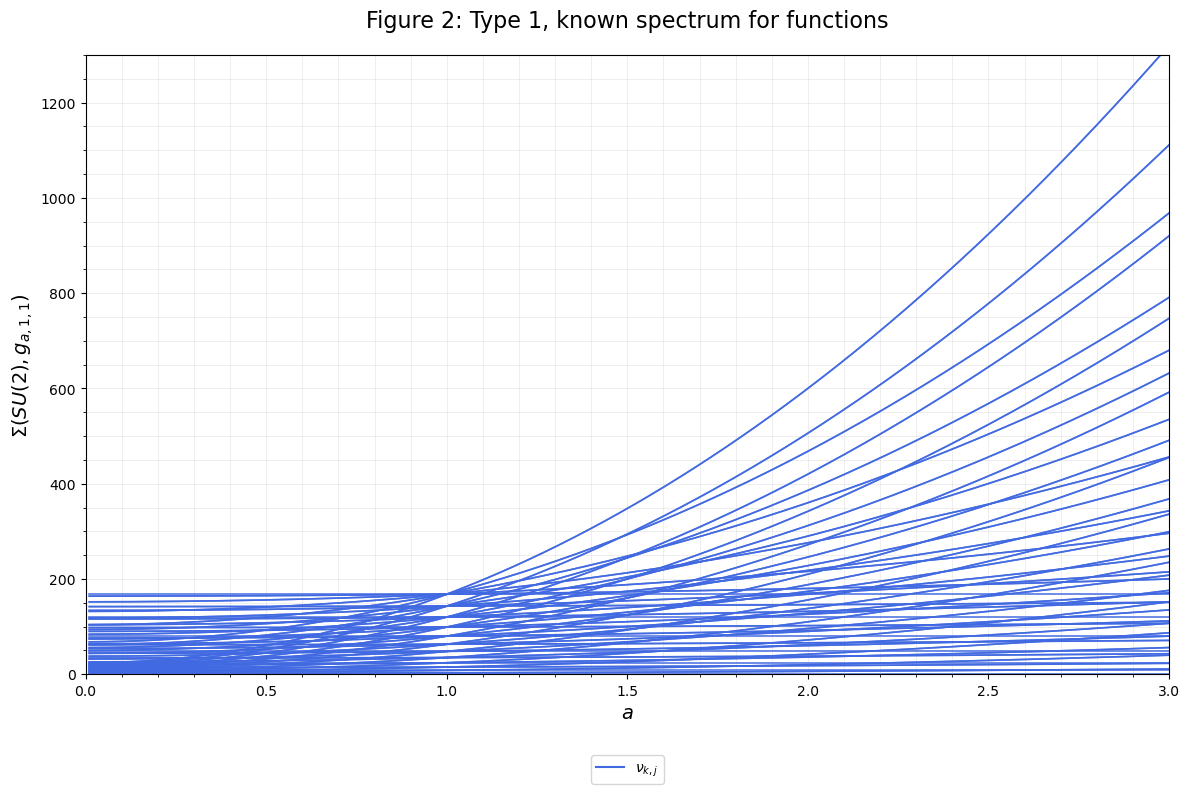

In [10]:
plot_berger_spectrum(k_max=12, a_max=3.0, y_max=1300, 
                     title="Figure 2: Type 1, known spectrum for functions",
                     show_mu_bound=False, show_mu_center=False, show_mu_plus=False, show_mu_minus=False)

### Type $4^+$: Upper Splitting Branch (Figure 3)

This plot shows the upper branch of the eigenvalues resulting from the complicated splitting behavior. These values are strictly larger than the corresponding function eigenvalues ($\nu_{k,j}$).

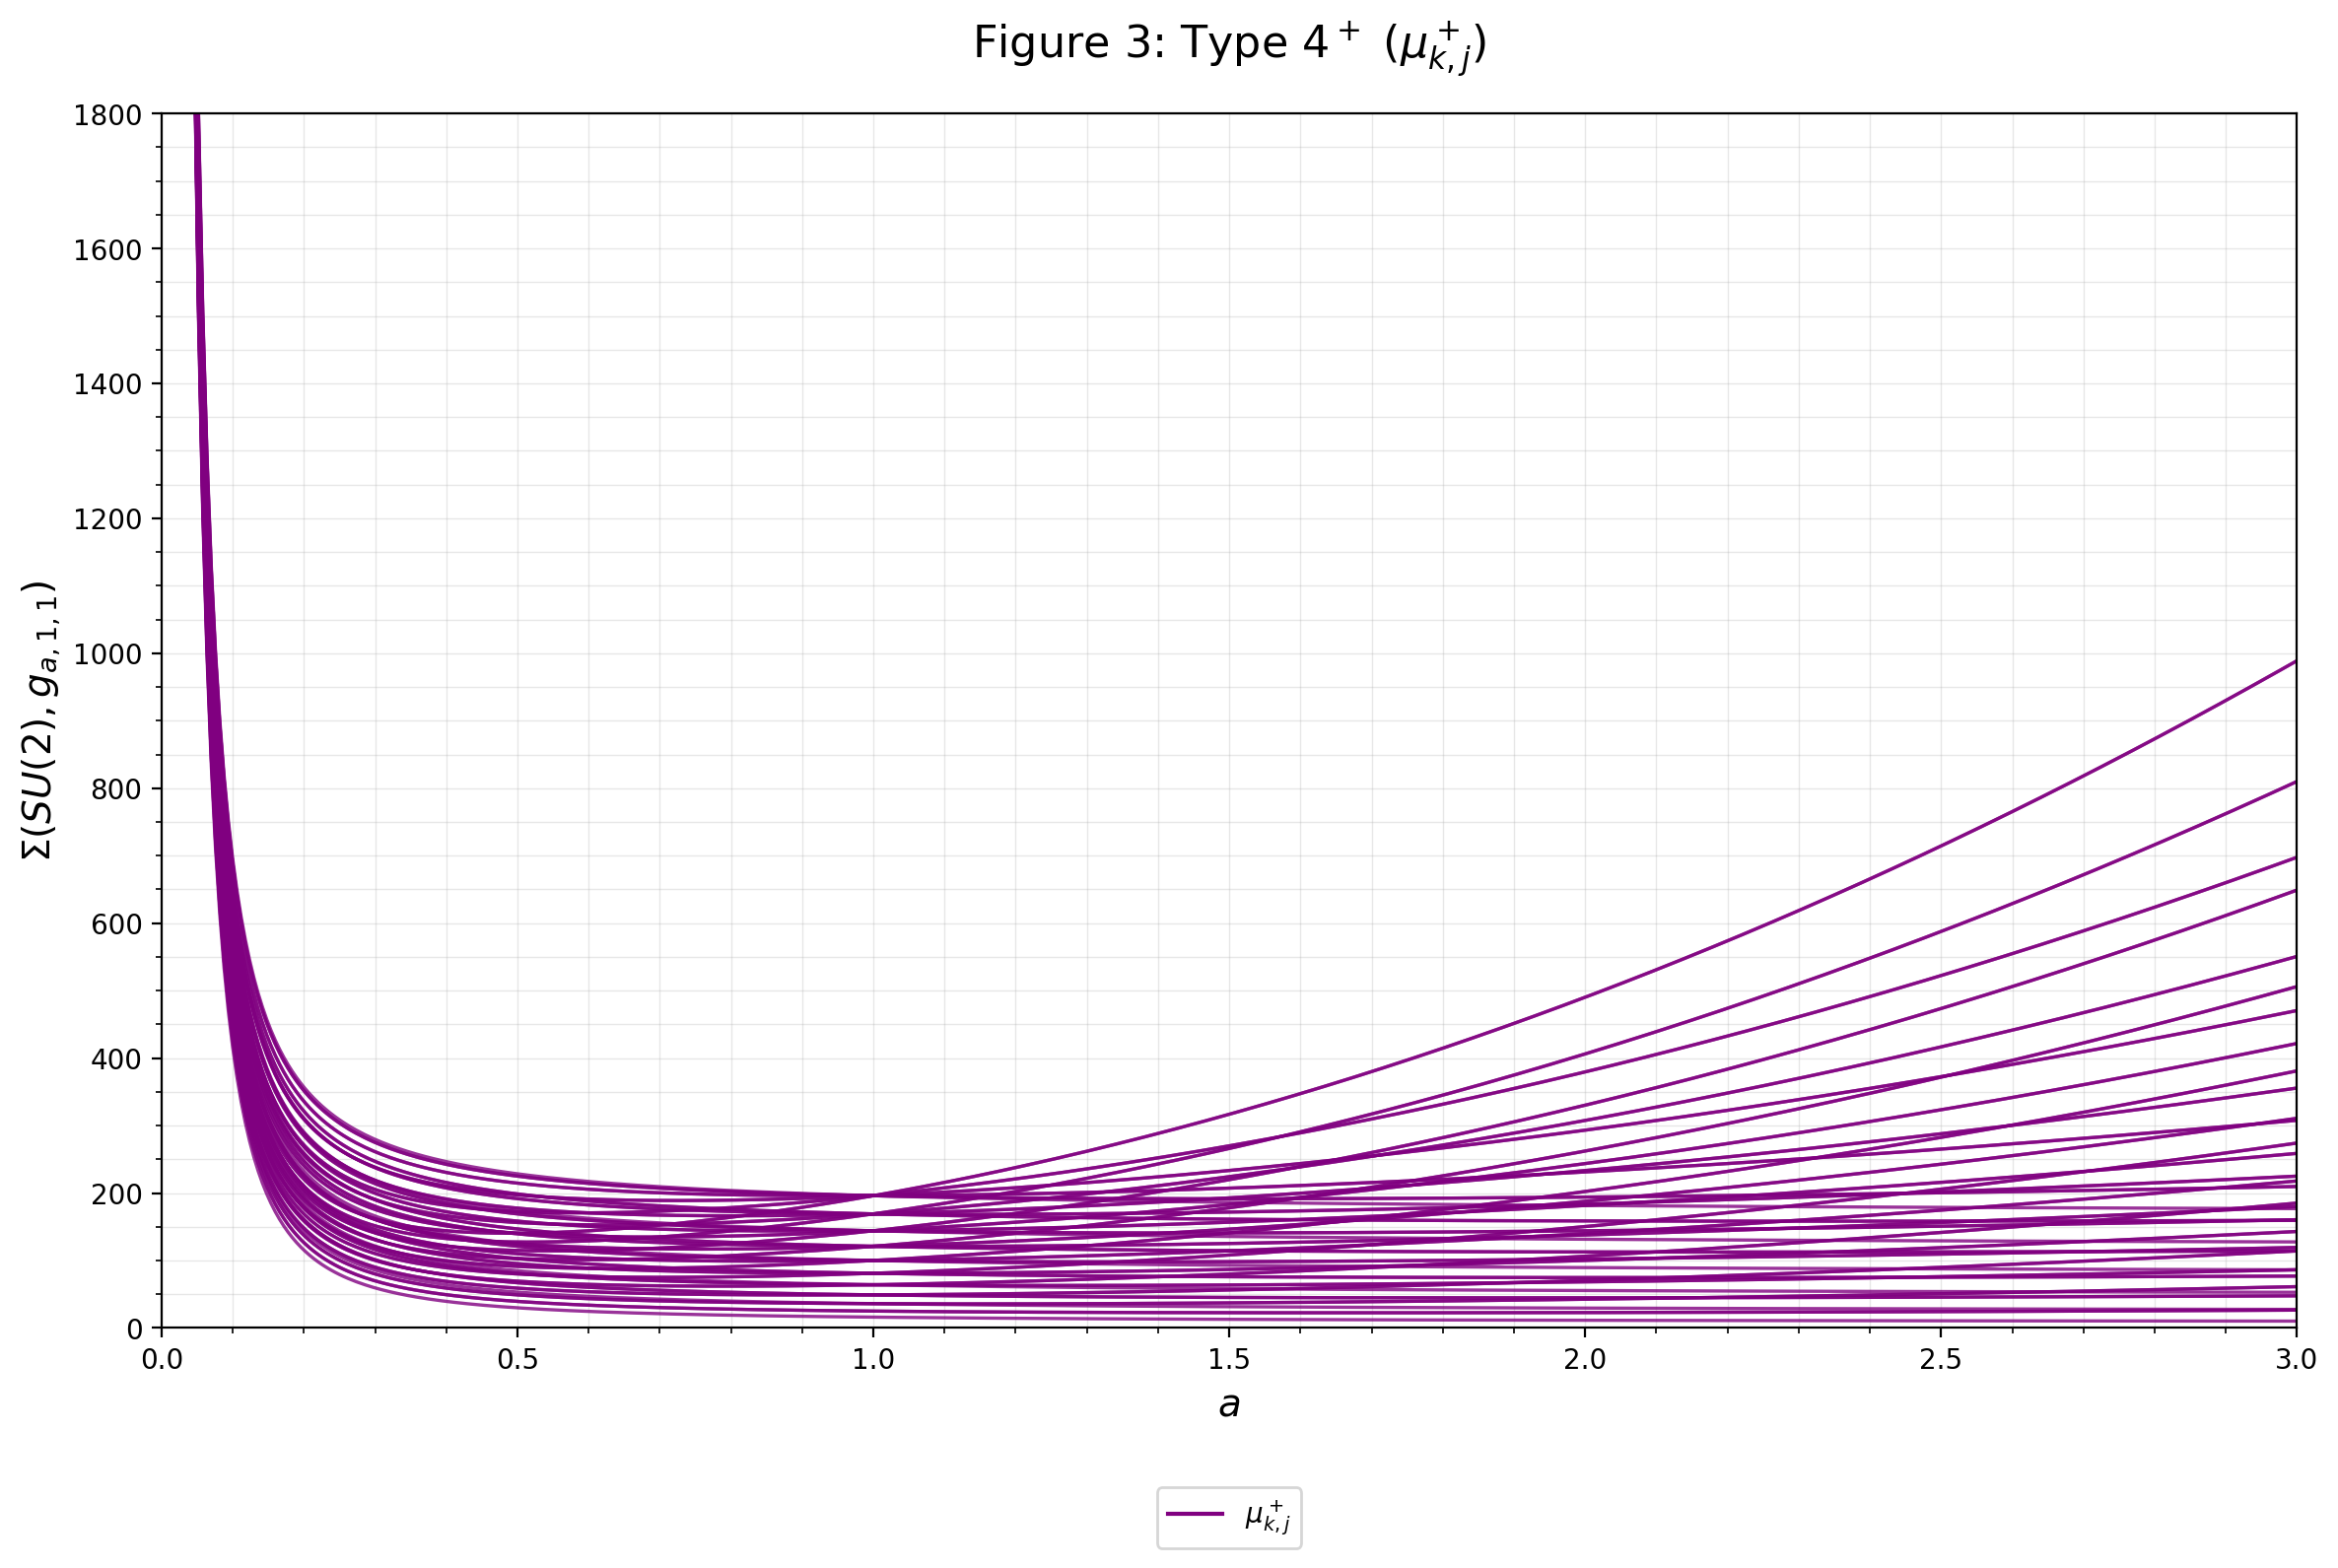

In [18]:
plot_berger_spectrum(k_max=12, a_max=3.0, y_max=1800, 
                     title=r"Figure 3: Type $4^+$ ($\mu_{k,j}^+$)",
                     show_nu=False, show_mu_bound=False, show_mu_center=False, show_mu_minus=False)

### Type 3 (Figure 4)

These eigenvalues (specifically $\mu_{k,k}$) contain a term proportional to $1/a^2$.
*   For $k=0$, this eigenvalue tends to 0 as $a \to \infty$, making it the smallest eigenvalue in the limit of large deformations.
*   For $k>0$, the term $k^2 a^2$ causes the eigenvalue to diverge to infinity for large $a$.

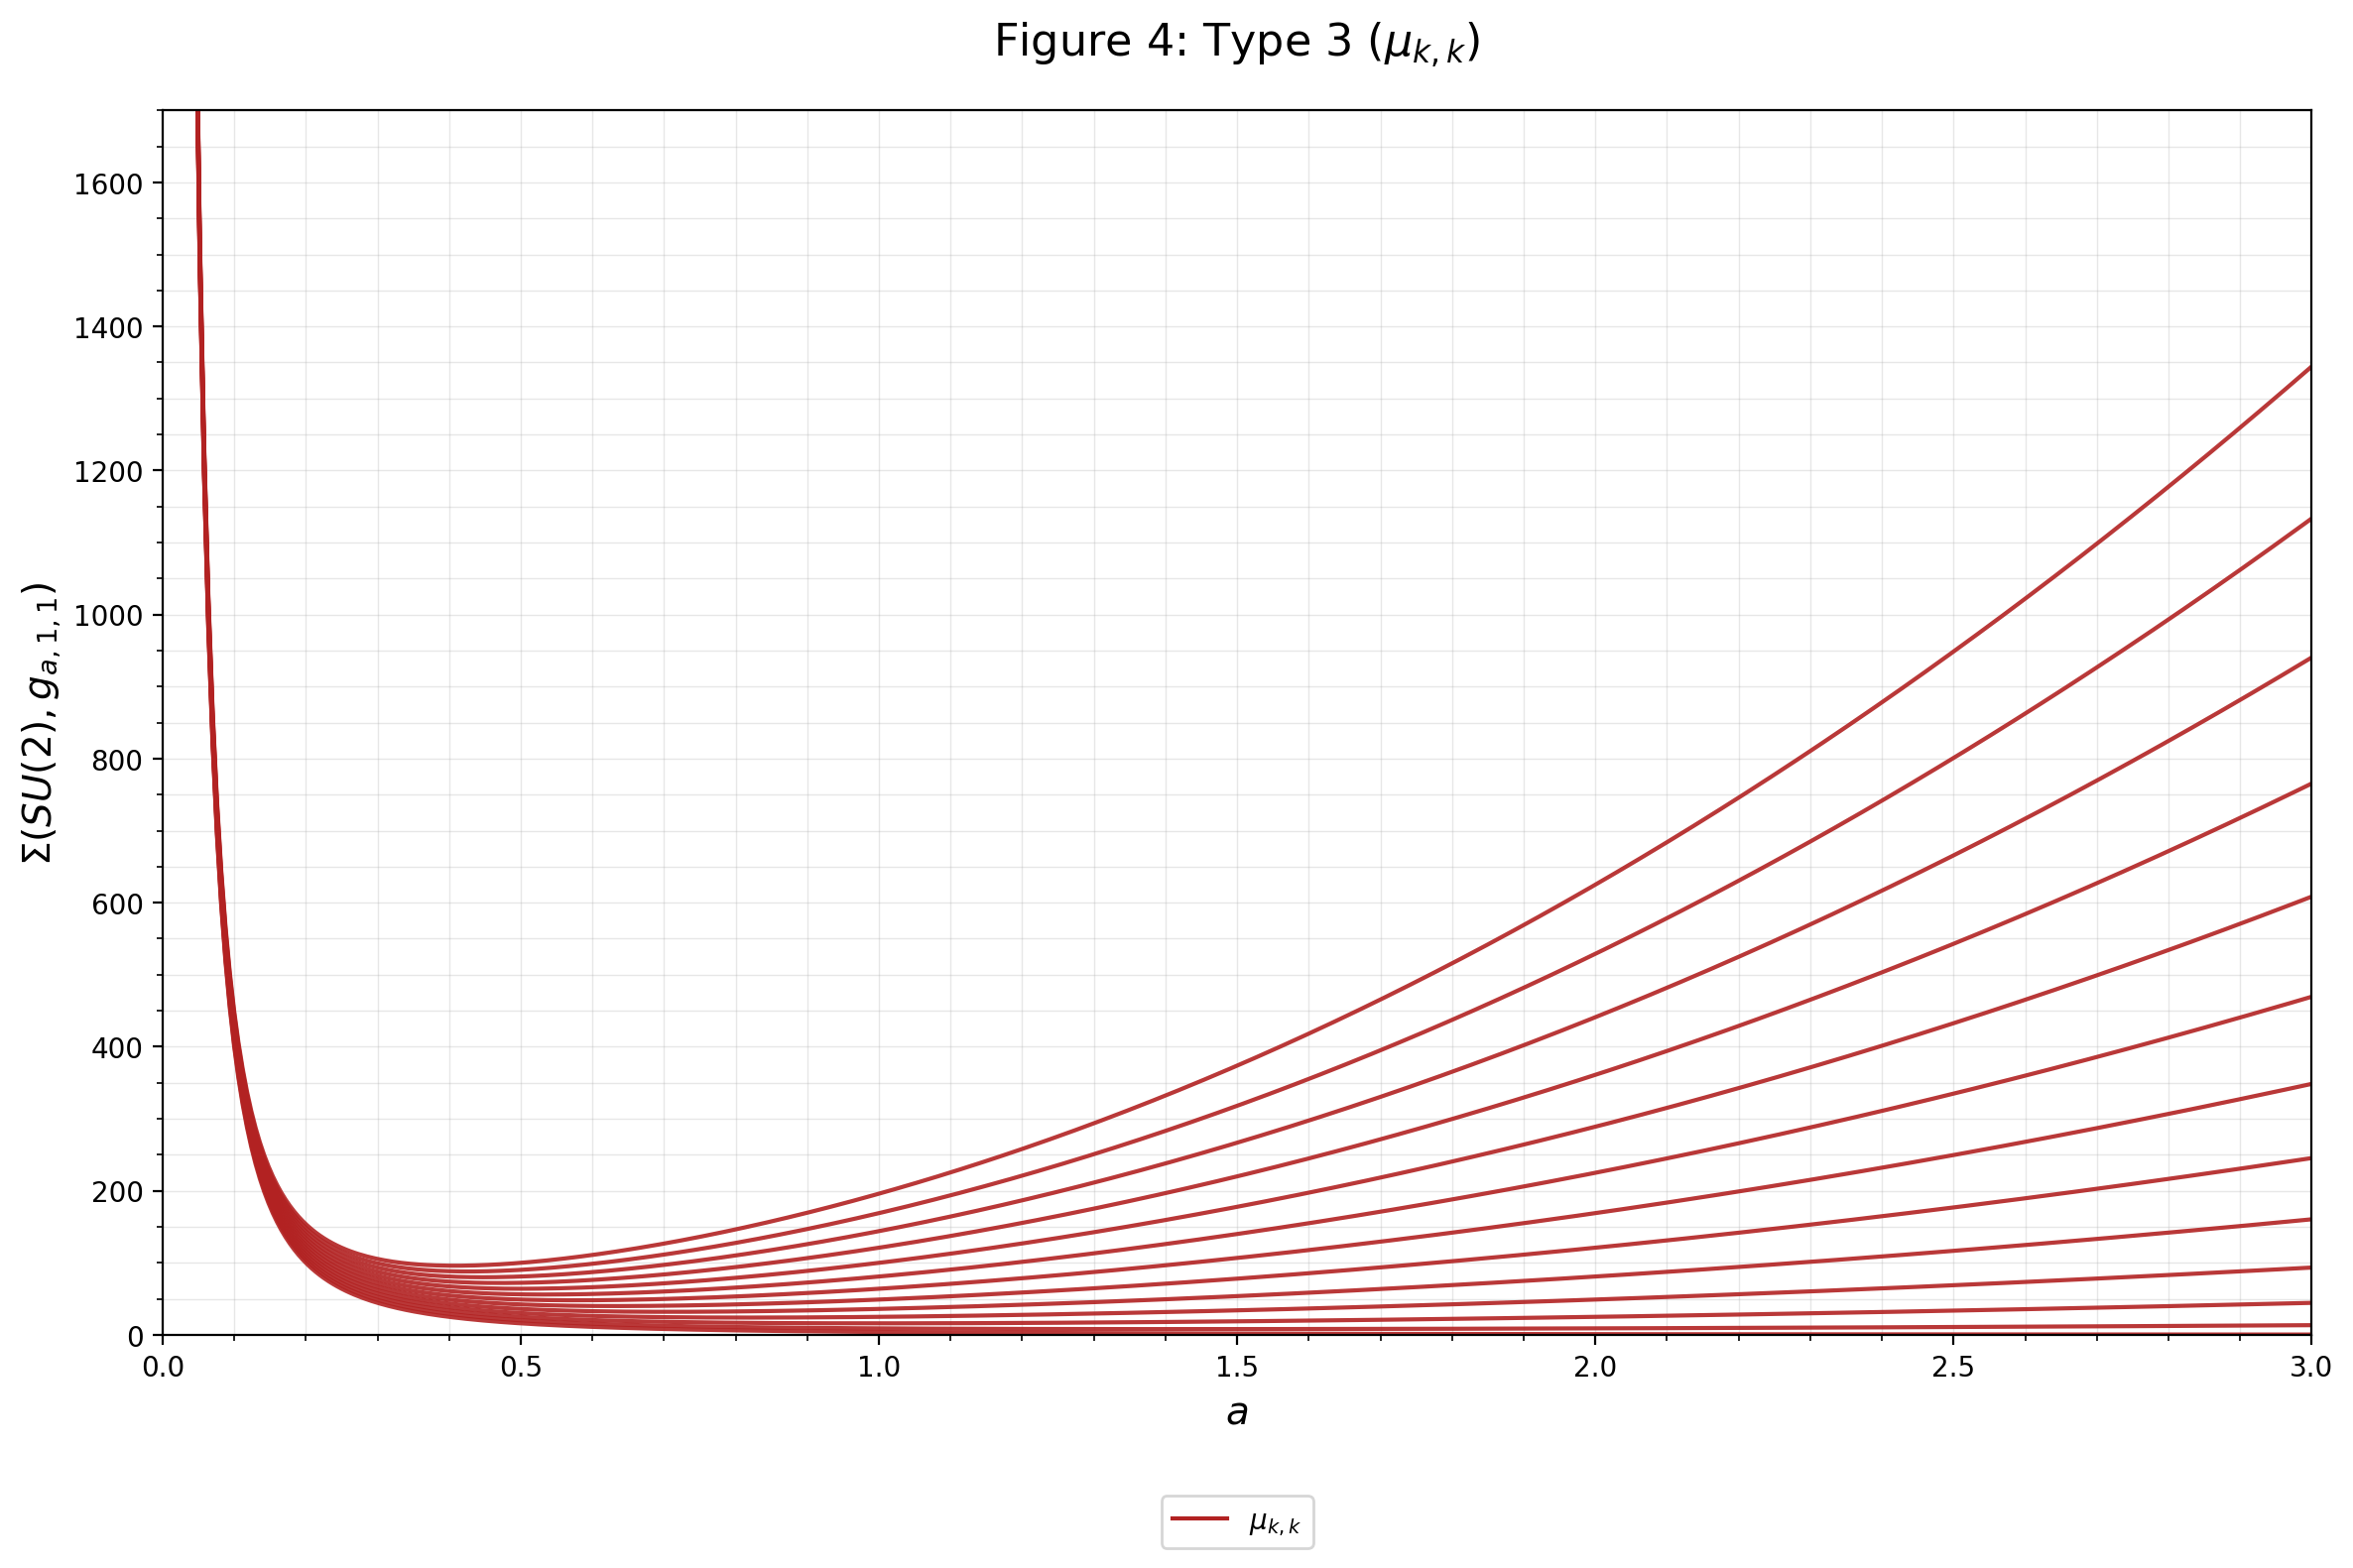

In [17]:
plot_berger_spectrum(k_max=12, a_max=3.0, y_max=1700, 
                     title=r"Figure 4: Type 3 ($\mu_{k,k}$)",
                     show_nu=False, show_mu_bound=False, show_mu_plus=False, show_mu_minus=False)

### Type $4^-$: Lower Splitting Branch (Figure 5)

This is the lower branch of the complicated splitting behavior. Analogous to the upper branch, these eigenvalues satisfy a strict ordering relation with the function spectrum:
$$ \mu_{k,j}^- < \nu_{k,j} $$

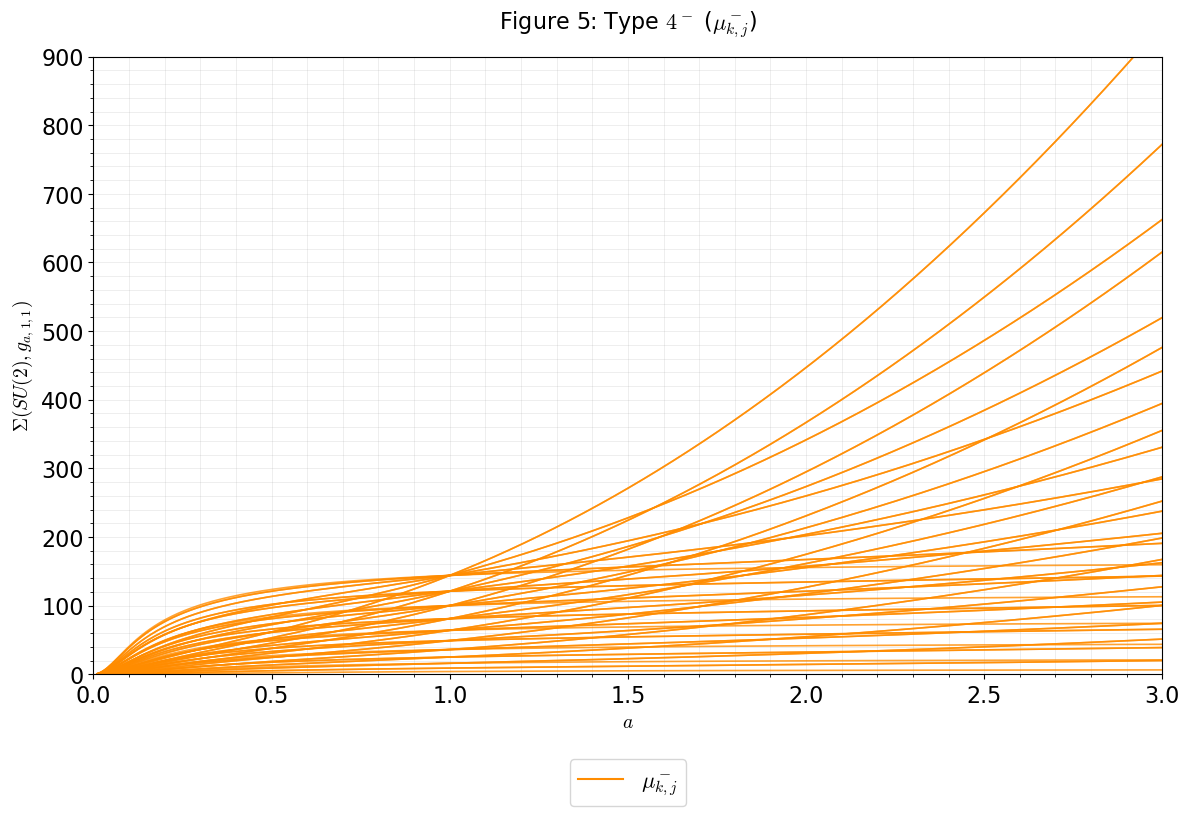

In [44]:
plot_berger_spectrum(k_max=12, a_max=3.0, y_max=900, 
                     title=r"Figure 5: Type $4^-$ ($\mu_{k,j}^-$)",
                     show_nu=False, show_mu_bound=False, show_mu_center=False, show_mu_plus=False)

### Type 2: The Vertical Branch (Figure 6)

These eigenvalues scale purely quadratically with $a$ ($\sim a^2$). They correspond to eigenforms that are primarily sensitive to the rescaling of the fiber metric.

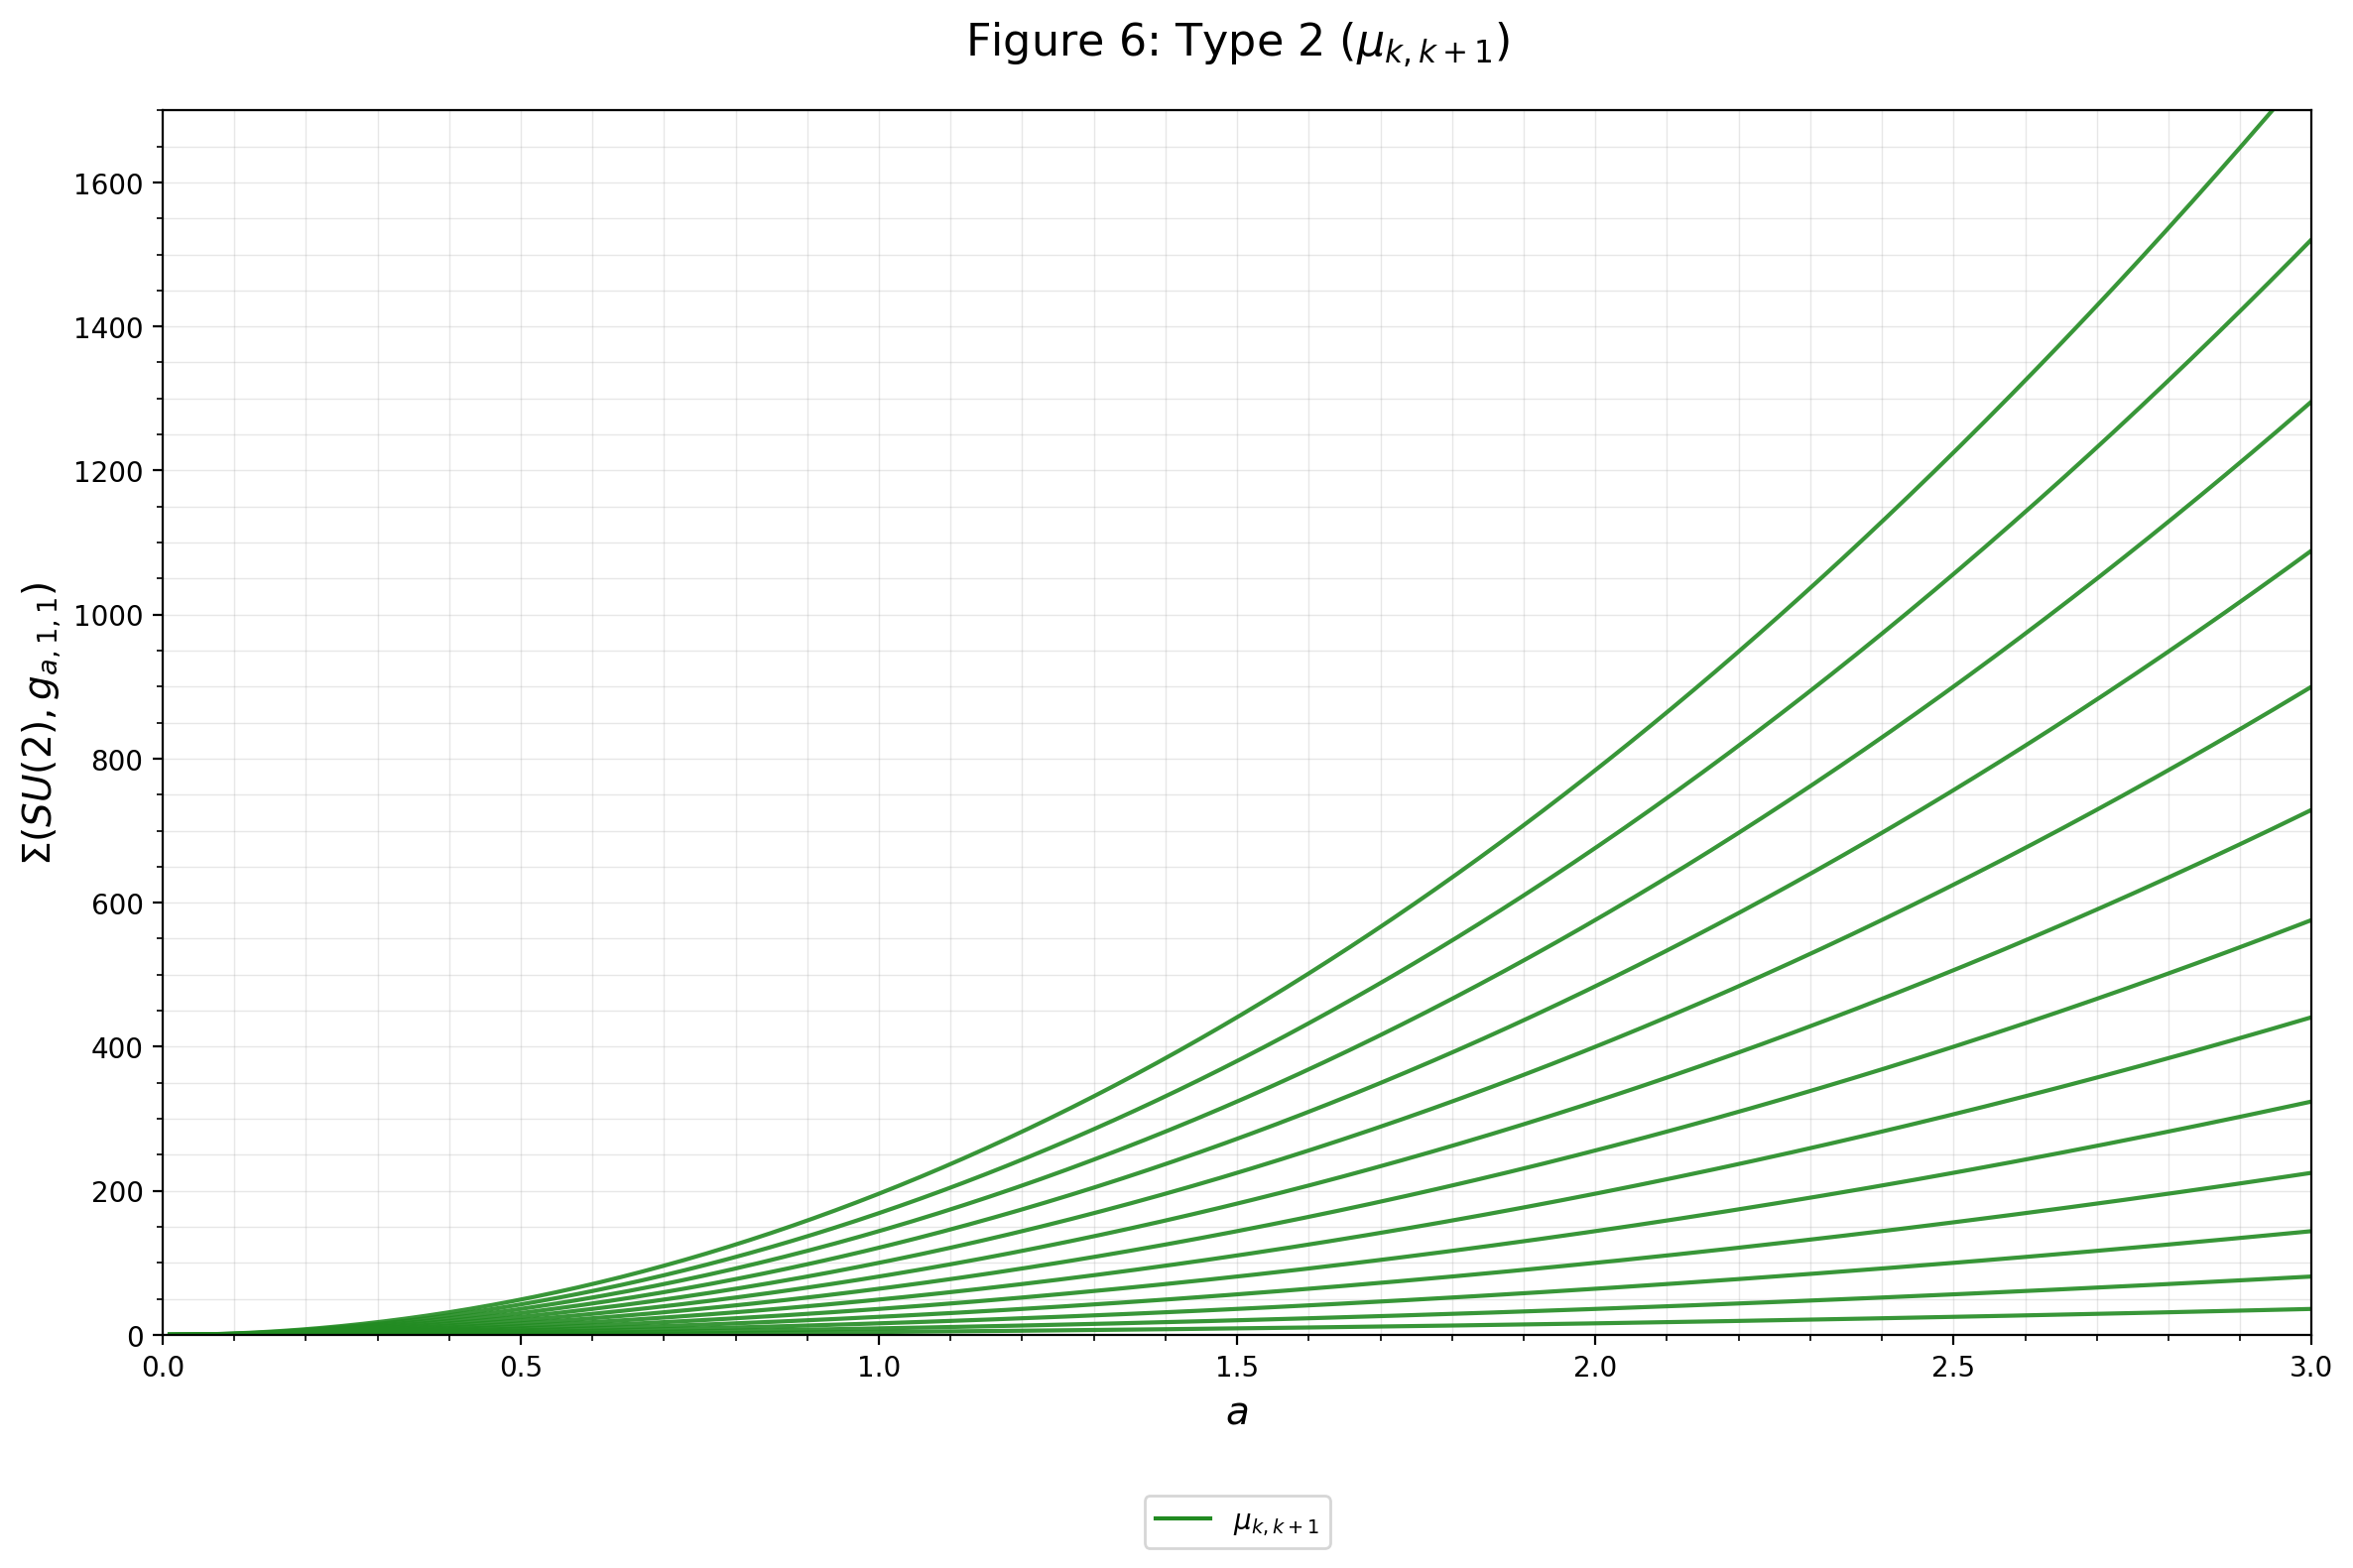

In [16]:
plot_berger_spectrum(k_max=12, a_max=3.0, y_max=1700, 
                     title=r"Figure 6: Type 2 ($\mu_{k,k+1}$)",
                     show_nu=False, show_mu_center=False, show_mu_plus=False, show_mu_minus=False)

### Spectrum of $\Delta|_{\varrho(13)}$ (Figure 8)

This plot illustrates the spectrum for a fixed representation $k=13$.
A special feature is visible at **$a=1$** (the round sphere): The complex splitting of the eigenvalues collapses. We recover the *three distinct eigenvalues* of the standard round sphere:
1.  $\nu_{k,j} = k(k+2)$
2.  $\mu_{k, \cdot} = (k+2)^2$
3.  $\mu_{k,j}^- = k^2$

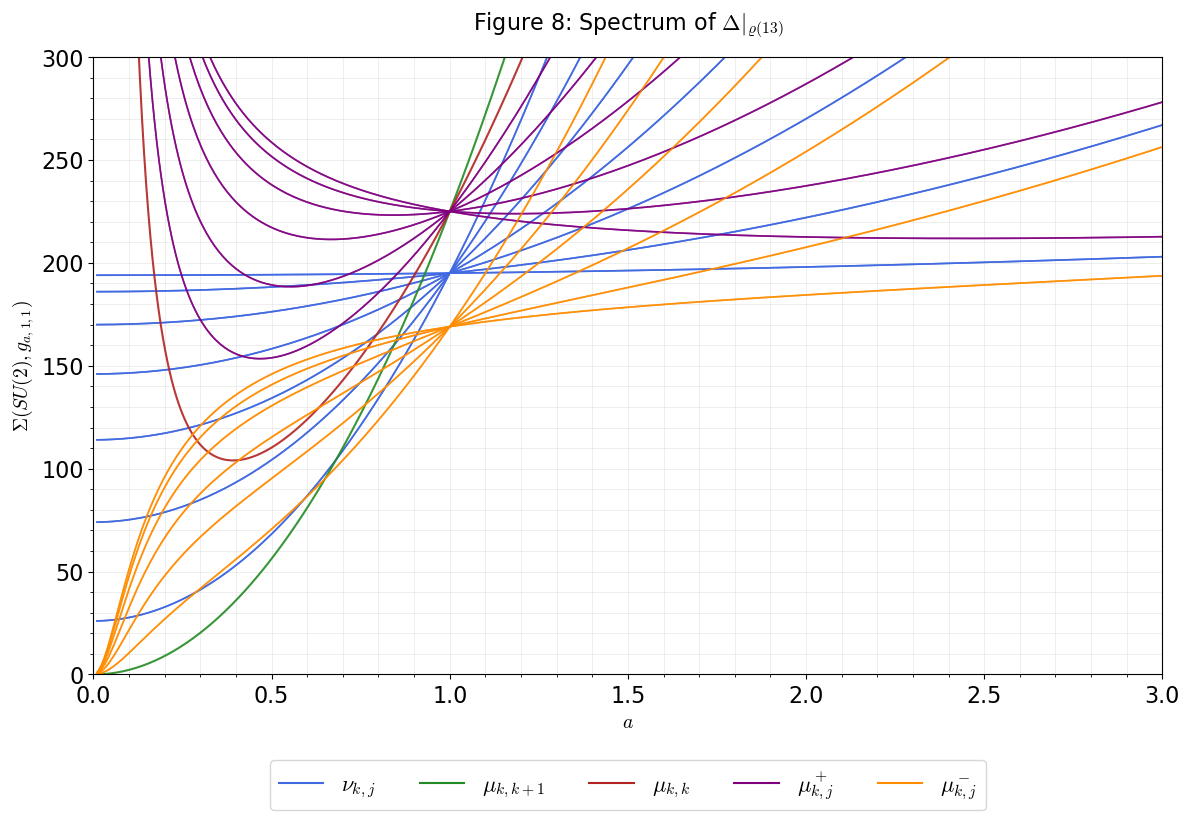

In [48]:
plot_berger_spectrum(specific_k=13, a_max=3.0, y_max=300, 
                     title=r"Figure 8: Spectrum of $\Delta|_{\varrho(13)}$")

### Spectrum of $\Delta|_{\varrho(60)}$ (Figure 9)

This plot illustrates the spectrum for $k=60$. For large deformation parameters $a$, the spectrum organizes into distinct bands. We observe the strict *ordering relation* (valid for all $k \ge 2$):
$$ \mu_{k,k+1} > \mu_{k,k} > \mu_{k,j}^+ > \nu_{k,j} > \mu_{k,j}^- $$

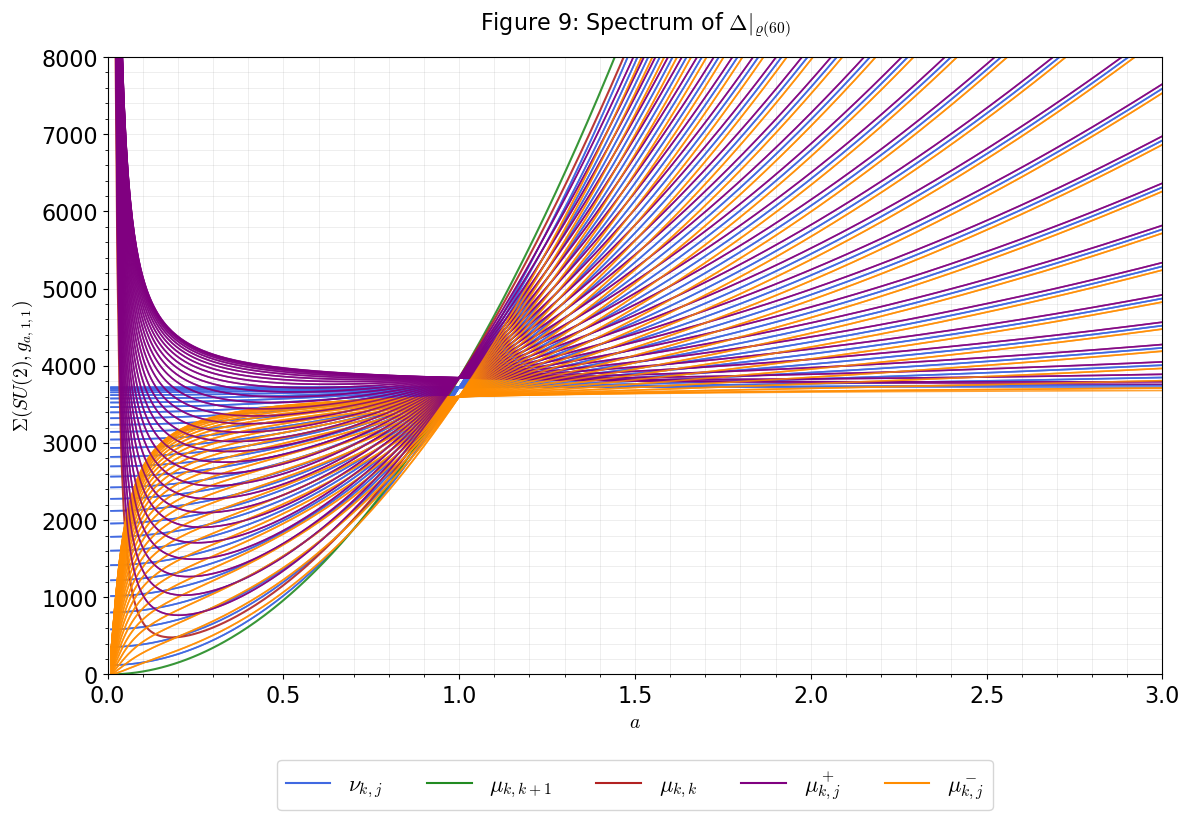

In [49]:
plot_berger_spectrum(specific_k=60, a_max=3.0, y_max=8000, 
                     title=r"Figure 9: Spectrum of $\Delta|_{\varrho(60)}$")

### Full Spectrum for Large Deformations (Figure 10)

This plot visualizes the global behavior of the spectrum over a large range of $a$.

**Asymptotic Behavior:**
1.  **Collapse to 0:** The first eigenvalue tends to 0 in both limits.
2.  **Divergence to $\infty$:** Simultaneously, a large number of eigenvalues diverge to infinity.
    *   As $a \to \infty$, the Type 2 eigenvalues (Green) scale with $a^2$ and shoot up.
    *   As $a \to 0$, the Type 3 eigenvalues (Red) scale with $1/a^2$ and diverge.

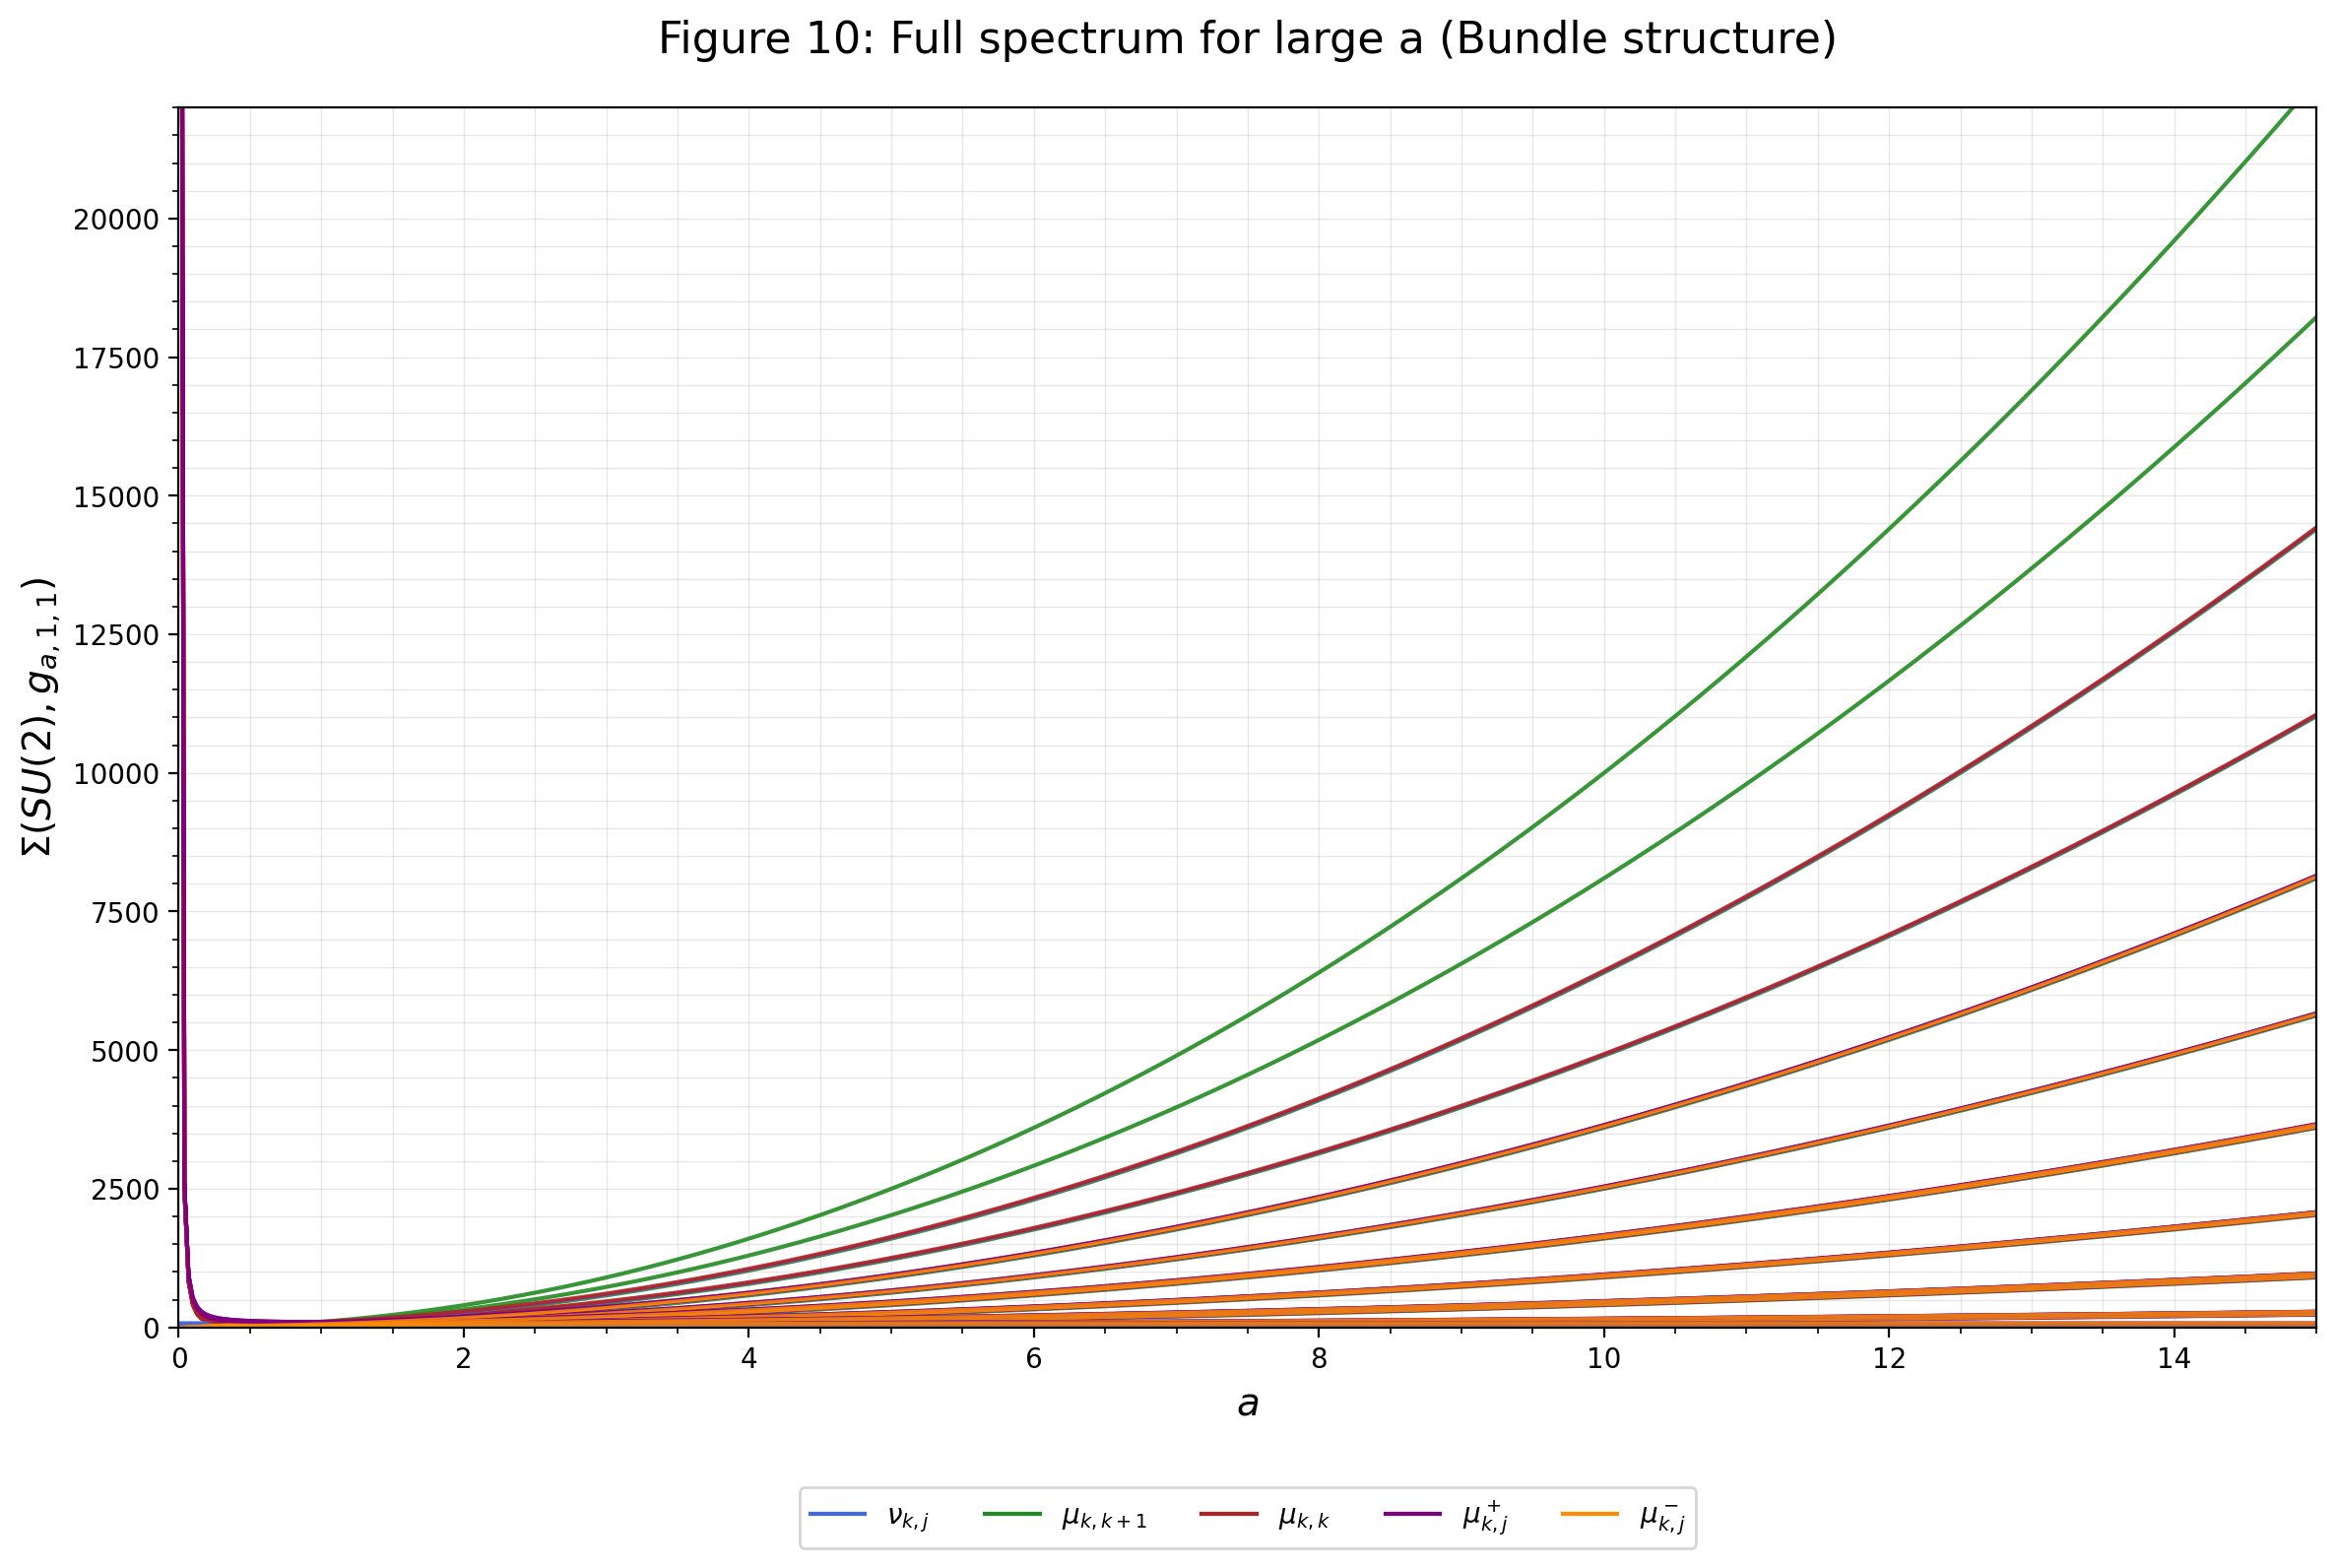

In [15]:
plot_berger_spectrum(k_max=8, a_max=15.0, y_max=22000, 
                     title="Figure 10: Full spectrum for large a (Bundle structure)")